# 使用领域（私有）数据微调 ChatGLM3

生成带有 epoch 和 timestamp 的模型文件

In [1]:
import torch

print(torch.__config__.show(), torch.cuda.get_device_properties(0))

PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.9.2
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.9.2, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINET

In [2]:
# 定义全局变量和参数
model_name_or_path = 'THUDM/chatglm3-6b'  # 模型ID或本地路径
# train_data_path = 'data/zhouyi_dataset_handmade.csv'    # 训练数据路径
train_data_path = 'data/zhouyi_dataset_20240118_163659.csv'    # 训练数据路径(批量生成数据集）
eval_data_path = None                     # 验证数据路径，如果没有则设置为None
seed = 8                                 # 随机种子
max_input_length = 512                    # 输入的最大长度
max_output_length = 1536                  # 输出的最大长度
lora_rank = 16                             # LoRA秩
lora_alpha = 32                           # LoRA alpha值
lora_dropout = 0.05                       # LoRA Dropout率
prompt_text = ''                          # 所有数据前的指令文本

## 数据处理

In [3]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files=train_data_path)
print(dataset)

/home/wangfuxin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['content', 'summary'],
        num_rows: 160
    })
})


In [4]:
dataset["train"][0] # 打印第一条数据以检查格式

{'content': '蒙卦代表什么？',
 'summary': '蒙卦是由艮卦（山）下，坎卦（水）上组成的异卦相叠。它代表着通泰，启蒙的意义。在这里，卜者并非是在向幼稚愚昧的人取求，而是幼稚愚昧的人在向卜者求教。第一次卜筮就得到了神灵的指示。然而，如果轻慢不敬地再三卜筮的话，神灵便不会再示警。总的来说，这是一个吉利的卜问。\n\n蒙卦的核心在于山下有泉的形象，寓意着启蒙。君子观此卦象，应当以果敢坚毅的行动来培养自身的品德，像山泉一样果断行动。然而，此卦乃是离宫四世卦，它代表着回还往复、疑惑不前、多忧愁过失，因而属于凶卦。\n\n蒙卦在个人发展、事业经商、求名婚恋等方面的解释不一。在事业方面，表示事业初建，具有启蒙和通达之象，需要勇敢坚毅的行动；而在经商方面，需要务必小心谨慎，树立高尚的商业道德，不可急功近利；求名方面，需要接受良好的基础教育，陶冶情操。整体而言，此卦提示须忍耐待机而动，听取别人意见，方能通达运势。'}

In [5]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [6]:
show_random_elements(dataset["train"], num_examples=5)

,content,summary
0,乾卦代表什么？,在周易中，乾卦是六十四卦之首，由六个阳爻组成，象征着天。它所代表的是刚健、健行、刚健不屈的意境。乾卦的核心哲学是：天道刚健，运行不已，君子观此卦象，从而以天为法，自强不息。\n\n乾卦象征天，为大通而至正。得此卦者，名利双收，应把握机会，争取成果。然而，切勿过于骄傲自满，而应保持谦逊、冷静和警惕。在事业、经商、求名等方面，乾卦皆暗示着大吉大利，但也警示着必须坚持正道、修养德行，方能永远亨通。\n\n在婚恋方面，乾卦提示着阳盛阴衰，但也强调刚柔相济，相互补足，形成美满的结果。在决策方面，则是强调刚健、正直、公允，自强不息的实质，需要修养德行、坚定信念，方能克服困难，消除灾难。
1,蒙卦和教育启蒙有什么联系？,蒙卦是由艮卦（山）下，坎卦（水）上组成的异卦相叠。它代表着通泰，启蒙的意义。在这里，卜者并非是在向幼稚愚昧的人取求，而是幼稚愚昧的人在向卜者求教。第一次卜筮就得到了神灵的指示。然而，如果轻慢不敬地再三卜筮的话，神灵便不会再示警。总的来说，这是一个吉利的卜问。\n\n蒙卦的核心在于山下有泉的形象，寓意着启蒙。君子观此卦象，应当以果敢坚毅的行动来培养自身的品德，像山泉一样果断行动。然而，此卦乃是离宫四世卦，它代表着回还往复、疑惑不前、多忧愁过失，因而属于凶卦。\n\n蒙卦在个人发展、事业经商、求名婚恋等方面的解释不一。在事业方面，表示事业初建，具有启蒙和通达之象，需要勇敢坚毅的行动；而在经商方面，需要务必小心谨慎，树立高尚的商业道德，不可急功近利；求名方面，需要接受良好的基础教育，陶冶情操。整体而言，此卦提示须忍耐待机而动，听取别人意见，方能通达运势。
2,请描述坤卦的含义。,坤卦，是周易中的一卦，由两个坤卦叠加而成，代表大地的顺从和承载。在这个卦中，预示着大吉大利，预言了雌马牵动的吉兆，君子出行会先迷失，后来找到主人，有利的方向是西南，不利的方向是东北。总体上，这是一个吉利的卦象。《象辞》中讲到，大地形势平和，君子观卦以厚德载物。坤卦的解释中提到，坤卦代表柔顺和地气舒展之象，主张妥善安排，等待时机，宜顺从运势以制定大事。在传统解卦中，坤卦代表谨慎行事，灵活适应，依循正道获得吉利。在事业、经商、婚姻和决策等方面，坤卦均主张顺从自然规律，勿急进，谋求长远利益。
3,周易比卦的核心思想是什么？,在周易中，比卦代表着相亲相依的意涵，它是由上卦坎（水）和下卦坤（地）相叠而成。这一卦象预示着长期的吉利和无咎，同时也暗示着不愿臣服的邦国迟迟不来朝会有难。\n\n比卦的核心哲学是：水附大地，地纳河海，象征相亲相依，亲密无间，展示出宽宏无私，精诚团结的道理。因此，在这一卦象中，人们可以得到贵人的提拔，事业可望成功，但需诚实、信任地做事，待人宽厚、正直，主动热情。在经商中，也需真诚交往，遵守商业道德，不可贪心不足或自以为是。\n\n比卦的运势平顺，事业顺利可望成功，可得贵人提拔。经商方面，愿望能够实现且有利润，但需与他人密切合作，讲究商业道德。在婚恋方面，象征着美好姻缘和相亲相爱。在决策中，建议心地善良，待人忠诚、厚道，工作勤恳并善于选择朋友。
4,在周易中，乾卦象征着什么？,在周易中，乾卦是六十四卦之首，由六个阳爻组成，象征着天。它所代表的是刚健、健行、刚健不屈的意境。乾卦的核心哲学是：天道刚健，运行不已，君子观此卦象，从而以天为法，自强不息。\n\n乾卦象征天，为大通而至正。得此卦者，名利双收，应把握机会，争取成果。然而，切勿过于骄傲自满，而应保持谦逊、冷静和警惕。在事业、经商、求名等方面，乾卦皆暗示着大吉大利，但也警示着必须坚持正道、修养德行，方能永远亨通。\n\n在婚恋方面，乾卦提示着阳盛阴衰，但也强调刚柔相济，相互补足，形成美满的结果。在决策方面，则是强调刚健、正直、公允，自强不息的实质，需要修养德行、坚定信念，方能克服困难，消除灾难。


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,
                                          trust_remote_code=True,
                                          revision='b098244')

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# tokenize_func 函数
def tokenize_func(example, tokenizer, ignore_label_id=-100):
    """
    对单个数据样本进行tokenize处理。

    参数:
    example (dict): 包含'content'和'summary'键的字典，代表训练数据的一个样本。
    tokenizer (transformers.PreTrainedTokenizer): 用于tokenize文本的tokenizer。
    ignore_label_id (int, optional): 在label中用于填充的忽略ID，默认为-100。

    返回:
    dict: 包含'tokenized_input_ids'和'labels'的字典，用于模型训练。
    """

    # 构建问题文本
    question = prompt_text + example['content']
    if example.get('input', None) and example['input'].strip():
        question += f'\n{example["input"]}'

    # 构建答案文本
    answer = example['summary']

    # 对问题和答案文本进行tokenize处理
    q_ids = tokenizer.encode(text=question, add_special_tokens=False) # 不添加特殊标记
    a_ids = tokenizer.encode(text=answer, add_special_tokens=False) 

    # 如果tokenize后的长度超过最大长度限制，则进行截断
    if len(q_ids) > max_input_length - 2:  # 保留空间给gmask和bos标记
        q_ids = q_ids[:max_input_length - 2]
    if len(a_ids) > max_output_length - 1:  # 保留空间给eos标记
        a_ids = a_ids[:max_output_length - 1]

    # 构建模型的输入格式
    input_ids = tokenizer.build_inputs_with_special_tokens(q_ids, a_ids) # 添加gmask和bos标记
    question_length = len(q_ids) + 2  # 加上gmask和bos标记

    # 构建标签，对于问题部分的输入使用ignore_label_id进行填充
    labels = [ignore_label_id] * question_length + input_ids[question_length:] # 答案部分的标签保持不变

    return {'input_ids': input_ids, 'labels': labels} # 对于答案部分的标签保持不变


In [9]:
column_names = dataset['train'].column_names 
tokenized_dataset = dataset['train'].map( 
    lambda example: tokenize_func(example, tokenizer), # 对每个样本进行tokenize处理
    batched=False, # 不使用批处理
    remove_columns=column_names # 保留原始列名以便后续处理
)

In [10]:
tokenized_dataset = tokenized_dataset.shuffle(seed=seed) # 打乱数据集
tokenized_dataset = tokenized_dataset.flatten_indices() # 重置索引

In [11]:
import torch
from typing import List, Dict, Optional

# DataCollatorForChatGLM 类
class DataCollatorForChatGLM:
    """
    用于处理批量数据的DataCollator，尤其是在使用 ChatGLM 模型时。

    该类负责将多个数据样本（tokenized input）合并为一个批量，并在必要时进行填充(padding)。

    属性:
    pad_token_id (int): 用于填充(padding)的token ID。
    max_length (int): 单个批量数据的最大长度限制。
    ignore_label_id (int): 在标签中用于填充的ID。
    """

    def __init__(self, pad_token_id: int, max_length: int = 2048, ignore_label_id: int = -100):
        """
        初始化DataCollator。

        参数:
        pad_token_id (int): 用于填充(padding)的token ID。
        max_length (int): 单个批量数据的最大长度限制。
        ignore_label_id (int): 在标签中用于填充的ID，默认为-100。
        """
        self.pad_token_id = pad_token_id
        self.ignore_label_id = ignore_label_id
        self.max_length = max_length

    def __call__(self, batch_data: List[Dict[str, List]]) -> Dict[str, torch.Tensor]:
        """
        处理批量数据。

        参数:
        batch_data (List[Dict[str, List]]): 包含多个样本的字典列表。

        返回:
        Dict[str, torch.Tensor]: 包含处理后的批量数据的字典。
        """
        # 计算批量中每个样本的长度
        len_list = [len(d['input_ids']) for d in batch_data]
        batch_max_len = max(len_list)  # 找到最长的样本长度

        input_ids, labels = [], []
        for len_of_d, d in sorted(zip(len_list, batch_data), key=lambda x: -x[0]):
            pad_len = batch_max_len - len_of_d  # 计算需要填充的长度
            # 添加填充，并确保数据长度不超过最大长度限制
            ids = d['input_ids'] + [self.pad_token_id] * pad_len # 确保填充到最大长度
            label = d['labels'] + [self.ignore_label_id] * pad_len # 答案部分的标签保持不变
            # 如果填充后的长度超过最大长度限制，则进行截断
            # 注意：这里的截断是为了确保数据不会超过模型的最大输入长度
            if batch_max_len > self.max_length:
                ids = ids[:self.max_length]
                label = label[:self.max_length]
            input_ids.append(torch.LongTensor(ids)) # 将输入ID转换为LongTensor
            labels.append(torch.LongTensor(label)) # 答案部分的标签保持不变

        # 将处理后的数据堆叠成一个tensor
        input_ids = torch.stack(input_ids) # 确保输入ID是一个tensor
        labels = torch.stack(labels) # 确保标签是一个tensor

        return {'input_ids': input_ids, 'labels': labels} 


In [12]:
# 准备数据整理器
data_collator = DataCollatorForChatGLM(pad_token_id=tokenizer.pad_token_id) # 用于处理批量数据的DataCollator，尤其是在使用 ChatGLM 模型时。

## 加载模型

In [13]:
from transformers import AutoModel, BitsAndBytesConfig

_compute_dtype_map = { # 映射不同精度类型到torch数据类型
    'fp32': torch.float32,
    'fp16': torch.float16,
    'bf16': torch.bfloat16
}

# QLoRA 量化配置
q_config = BitsAndBytesConfig(load_in_4bit=True, # 使用4位量化
                              bnb_4bit_quant_type='nf4', # 使用nf4量化类型
                              bnb_4bit_use_double_quant=True, # 使用双重量化
                              bnb_4bit_compute_dtype=_compute_dtype_map['bf16']) 
# 加载量化后模型
model = AutoModel.from_pretrained(model_name_or_path, # 加载模型
                                  quantization_config=q_config, # 使用量化配置
                                  device_map='auto', # 自动分配设备
                                  trust_remote_code=True, # 信任远程代码
                                  revision='b098244') # 指定模型版本

model.supports_gradient_checkpointing = True   # 启用梯度检查点
model.gradient_checkpointing_enable() # 启用梯度检查点
model.enable_input_require_grads() # 启用输入梯度计算

model.config.use_cache = False  # 禁用缓存以支持梯度计算
# silence the warnings. Please re-enable for inference!

/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]
/home/wangfuxin/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your m

In [14]:
from peft import TaskType, LoraConfig, get_peft_model, prepare_model_for_kbit_training
from peft.utils import TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING

kbit_model = prepare_model_for_kbit_training(model) # 准备LoRA配置
target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING['chatglm'] # 获取ChatGLM模型的目标模块

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [15]:
lora_config = LoraConfig( 
    target_modules=target_modules, # 指定LoRA目标模块
    r=lora_rank, # LoRA秩
    lora_alpha=lora_alpha, # LoRA alpha值
    lora_dropout=lora_dropout, # LoRA Dropout率
    bias='none', # 不使用偏置
    inference_mode=False, # 启用推理模式
    task_type=TaskType.CAUSAL_LM # 任务类型为因果语言模型
)

In [16]:
qlora_model = get_peft_model(kbit_model, lora_config) # 获取QLoRA模型
qlora_model.print_trainable_parameters() # 打印可训练参数的数量

trainable params: 3,899,392 || all params: 6,247,483,392 || trainable%: 0.06241540401681151


### QLoRA 微调模型

In [17]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") # 获取当前时间戳

train_epochs = 3 # 训练轮数
output_dir = f"models/{model_name_or_path}-epoch{train_epochs}-{timestamp}" # 输出目录，包含模型名称、训练轮数和时间戳

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_dir,                            # 输出目录
    per_device_train_batch_size=8,                     # 每个设备的训练批量大小
    gradient_accumulation_steps=1,                     # 梯度累积步数
    learning_rate=1e-3,                                # 学习率
    num_train_epochs=train_epochs,                     # 训练轮数
    lr_scheduler_type="linear",                        # 学习率调度器类型
    warmup_ratio=0.1,                                  # 预热比例
    logging_steps=5,                                 # 日志记录步数
    save_strategy="steps",                             # 模型保存策略
    save_steps=10,                                    # 模型保存步数
    optim="adamw_torch",                               # 优化器类型
    fp16=True,                                        # 是否使用混合精度训练
)


In [19]:
trainer = Trainer(
        model=qlora_model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator
    )

In [20]:
trainer.train() 

/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
5,4.399800
10,3.228500
15,1.964200
20,0.956300
25,0.267400
30,0.060900
35,0.020400
40,0.011900
45,0.006800
50,0.005600


/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/wangfuxin/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/wangfuxin/miniconda3/env

TrainOutput(global_step=60, training_loss=0.9109166638925672, metrics={'train_runtime': 416.1238, 'train_samples_per_second': 1.154, 'train_steps_per_second': 0.144, 'total_flos': 4623664398827520.0, 'train_loss': 0.9109166638925672, 'epoch': 3.0})

#### 训练时GPU使用情况

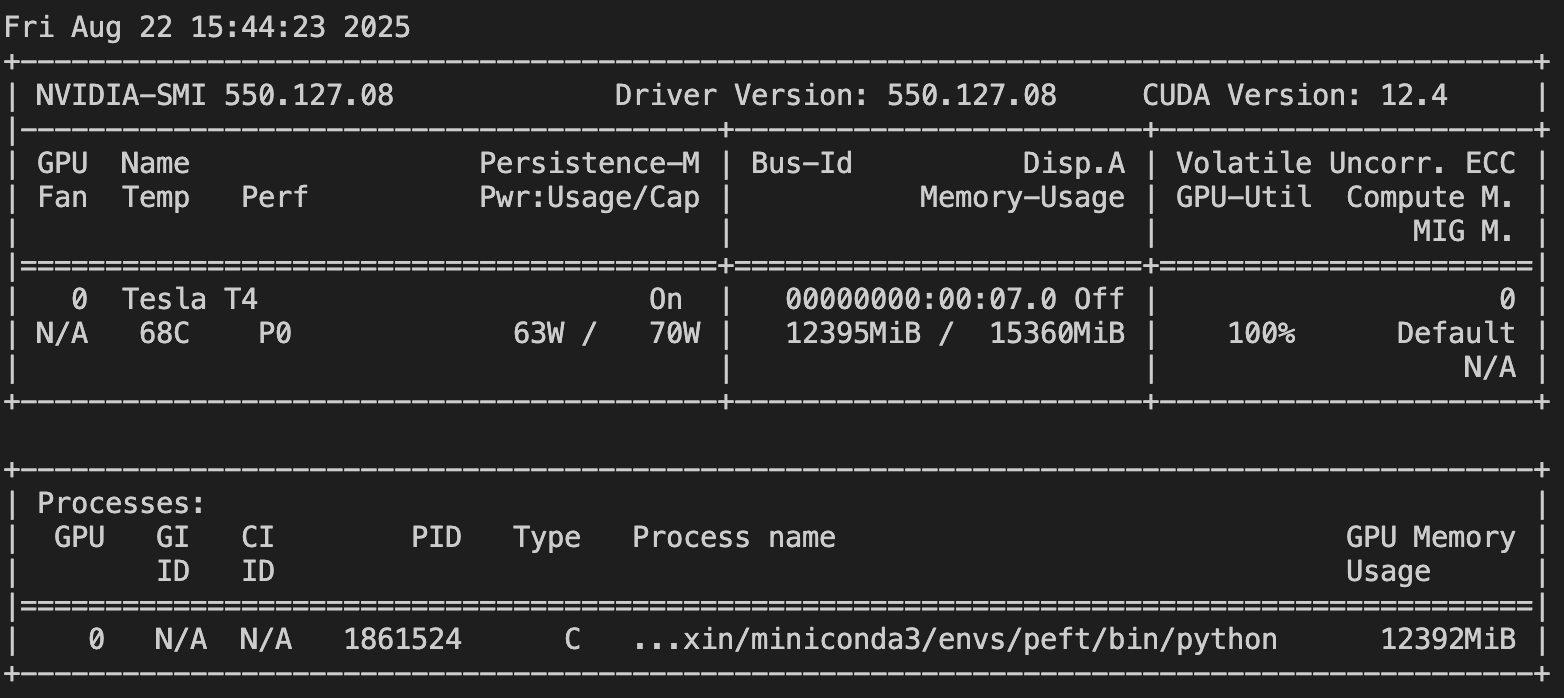

In [21]:
trainer.model.save_pretrained(output_dir)

#### 训练后存储的模型

```bash
(peft) wangfuxin@iZ6wearaq5de2lchqv8aovZ:~/LLM-quickstart-exec/chatglm/models/THUDM$ tree
.
└── chatglm3-6b-epoch3-20250822_154051
    ├── checkpoint-10
    ├── checkpoint-20
    ├── checkpoint-30
    ├── checkpoint-40
    ├── checkpoint-50
    └── checkpoint-60
```